# Análisis de Patrones de Luz en el Hackerspace San Salvador
Este Notebook contiene el análisis de los datos recolectados por los sensores de presencia instalados en el Hackerspace San Salvador.

## Información Técnica
* **Período de Recolección:** 12 de abril al 26 de abril de 2019
* **Variables recolectadas:**
    * Componente rojo de color (ISL29125)
    * Componente verde de color (ISL29125)
    * Componente azul de color (ISL29125)
    * Paquetes HTTP (Puerto 80) que transitan por el router
    * Paquetes SSL (Puerto 443) que transitan por el router
    * Activación de switch de luz
* **Limitantes de los datos recolectados**: Para el período de captura se identificó que el sensor de luz de color contenía datos faltantes. Se sospecha que la biblioteca que maneja el lector de luz está causando respuestas lentas y bloqueos en la lectura.

## Pre-procesamiento de datos
La base de datos almacena la fecha y la hora que se captura el indicador particular. Para generar un histórico minuto a minuto se utiliza un script que busca todos los valores que son capturados en períodos de un minuto.

En el caso del sensor de color la medición se promedia si se han realizado más de dos mediciones dentro de un período de un minuto.

El switch se considera activo si existe una sola medición de activación durante el período. Si no se encuentran registros durante el período se considera que el switch se encuentra apagado.

Los datos de paquetes se guardan tal cual, en caso de encontrarse más de una medición durante el período se suman ambas. Sin embargo, el número de paquetes se determina restando el valor de la medición actual contra la medición anterior. Como los conteos del router se reinician eventualmente, es posible encontrar algunos números negativos o conteos que se salen considerablemente del rango. Estos conteos han sido excluídos del análisis y se han reemplazado con 0.

### Normalización
Los rangos de lo valores son muy variantes entre sí, para poder graficar los parámetros y observar cambios se han escalado los rangos de tal manera que el máximo valor de cada variable se muestra como un 1 y el mínimo valor como 0. El valor se calcula con la fórmula valor/MAX(serie).

In [89]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

In [90]:
datafile = '../logs/log_20190412_20190426_processed.csv'
data = pd.read_csv(datafile, encoding='utf-8')
data.describe()

seq            r            g            b        switch  \
count  21600.000000  6001.000000  6001.000000  6001.000000  15514.000000   
mean   10800.500000   431.873521   450.337777   353.681886      0.103133   
std     6235.527243   643.113823   683.036924   542.963743      0.304142   
min        1.000000     1.000000     1.000000     0.000000      0.000000   
25%     5400.750000     1.000000     1.000000     0.000000      0.000000   
50%    10800.500000   143.000000   159.000000   128.000000      0.000000   
75%    16200.250000   526.000000   511.000000   406.000000      0.000000   
max    21600.000000  3056.000000  3442.000000  2958.000000      1.000000   

        http_packets   ssl_packets     diff_http      diff_ssl        norm_r  \
count    9693.000000  9.693000e+03  21600.000000  21600.000000  21600.000000   
mean    65540.425565  6.224530e+05      8.823194     67.308704      0.039262   
std     79058.382362  9.813107e+05    142.935934    436.930673      0.127709   
min       746.000000  0.000000e+00      0.000000      0.000000      0.000000   
25%     16274.000000  0.000000e+00      0.000000      0.000000      0.000000   
50%     16274.000000  0.000000e+00      0.000000      0.000000      0.000000   
75%    147569.000000  1.624458e+06      0.000000      0.000000      0.000327   
max    259383.000000  2.582606e+06   6135.000000  10722.000000      1.000000   

             norm_g        norm_b   norm_switch     norm_http      horm_ssl  
count  21600.000000  21600.000000  21600.000000  21600.000000  21600.000000  
mean       0.036349      0.033219      0.074074      0.001438      0.006278  
std        0.119891      0.110582      0.261897      0.023298      0.040751  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000291      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000

In [91]:
snapshots = pd.to_datetime(data['start'], format='%Y-%m-%d %H:%M:%S')

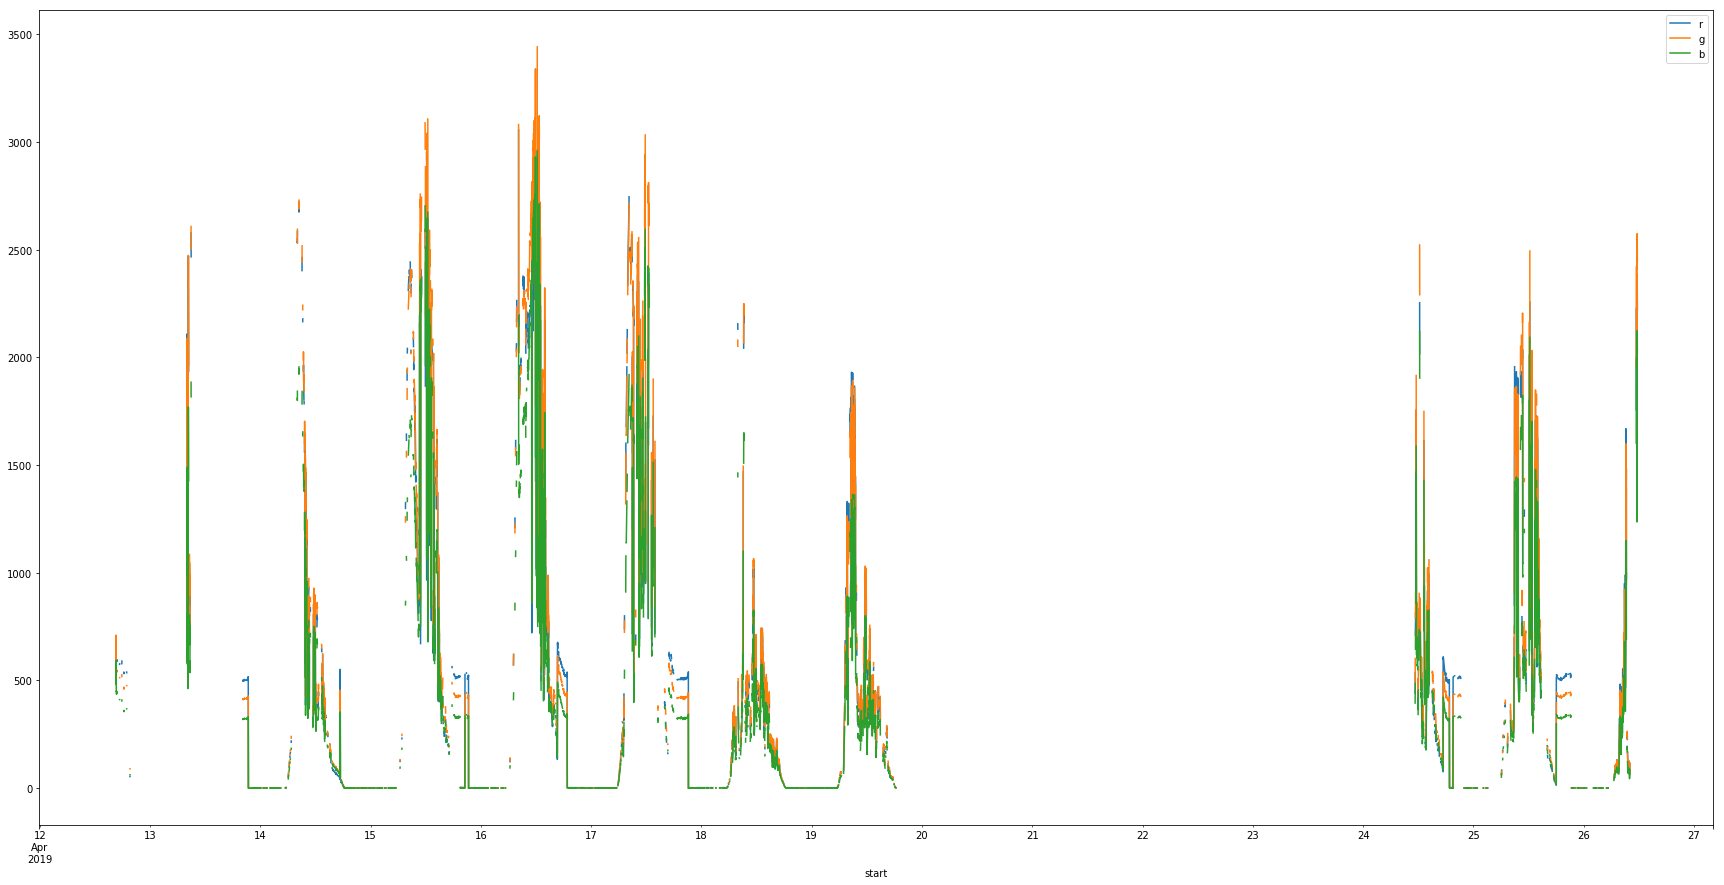

In [92]:
raw_rgb = data.filter(['r','g','b']).join(snapshots)
raw_rgb.plot.line(y=['r','g','b'],x='start',figsize=(30, 15)).get_figure().savefig('./img/raw_rgb_plot.png')

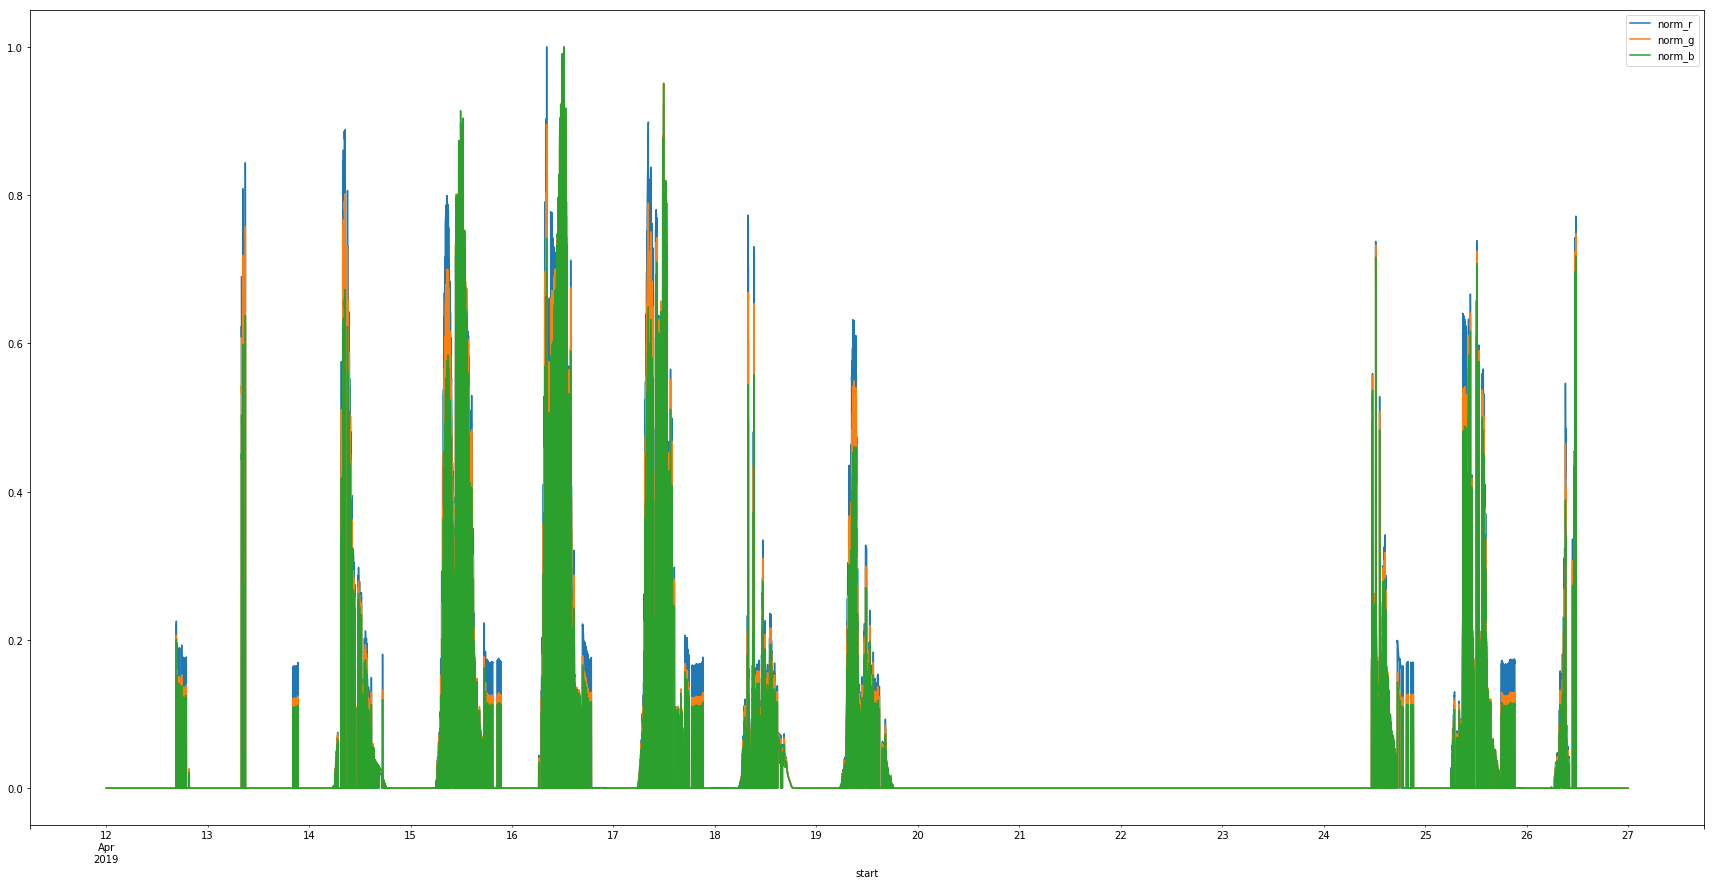

In [93]:
norm_rgb = data.filter(['norm_r','norm_g','norm_b']).join(snapshots)
norm_rgb.plot.line(y=['norm_r','norm_g','norm_b'],x='start',figsize=(30, 15)).get_figure().savefig('./img/norm_rgb_plot.png')

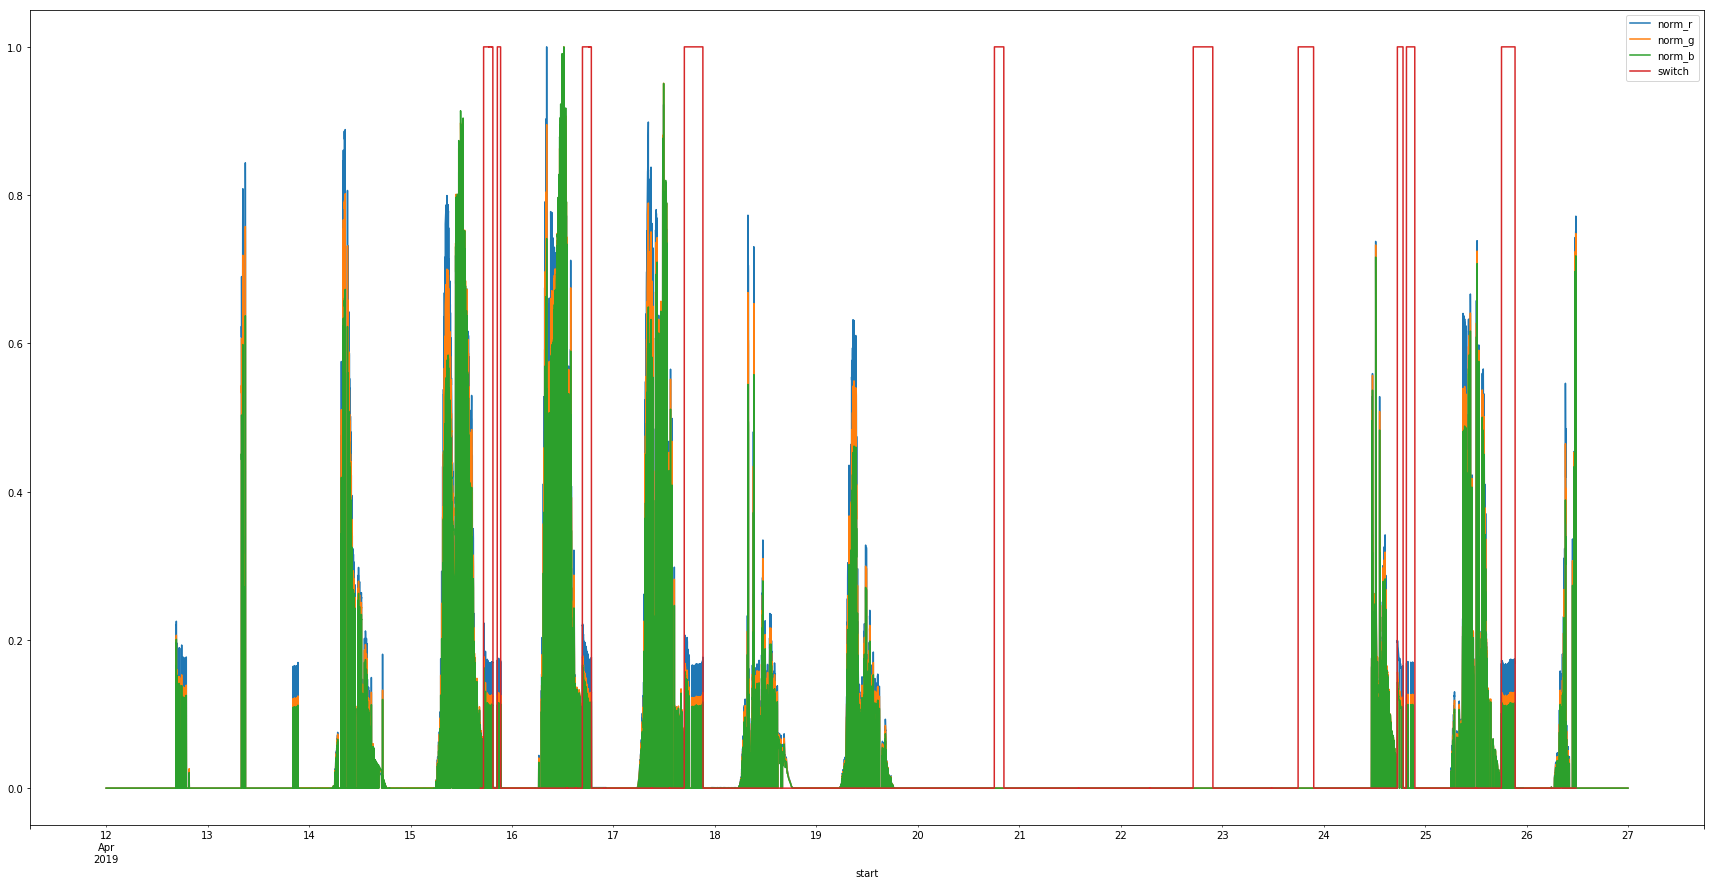

In [94]:
norm_rgb_switch = data.filter(['norm_r','norm_g','norm_b','switch']).join(snapshots)
norm_rgb_switch.plot.line(y=['norm_r','norm_g','norm_b','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/norm_rgb_switch_plot.png')

In [95]:
network = data.filter(['diff_http','diff_ssl']).join(snapshots)
network.plot.line(y=['diff_http','diff_ssl'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_plot.png')

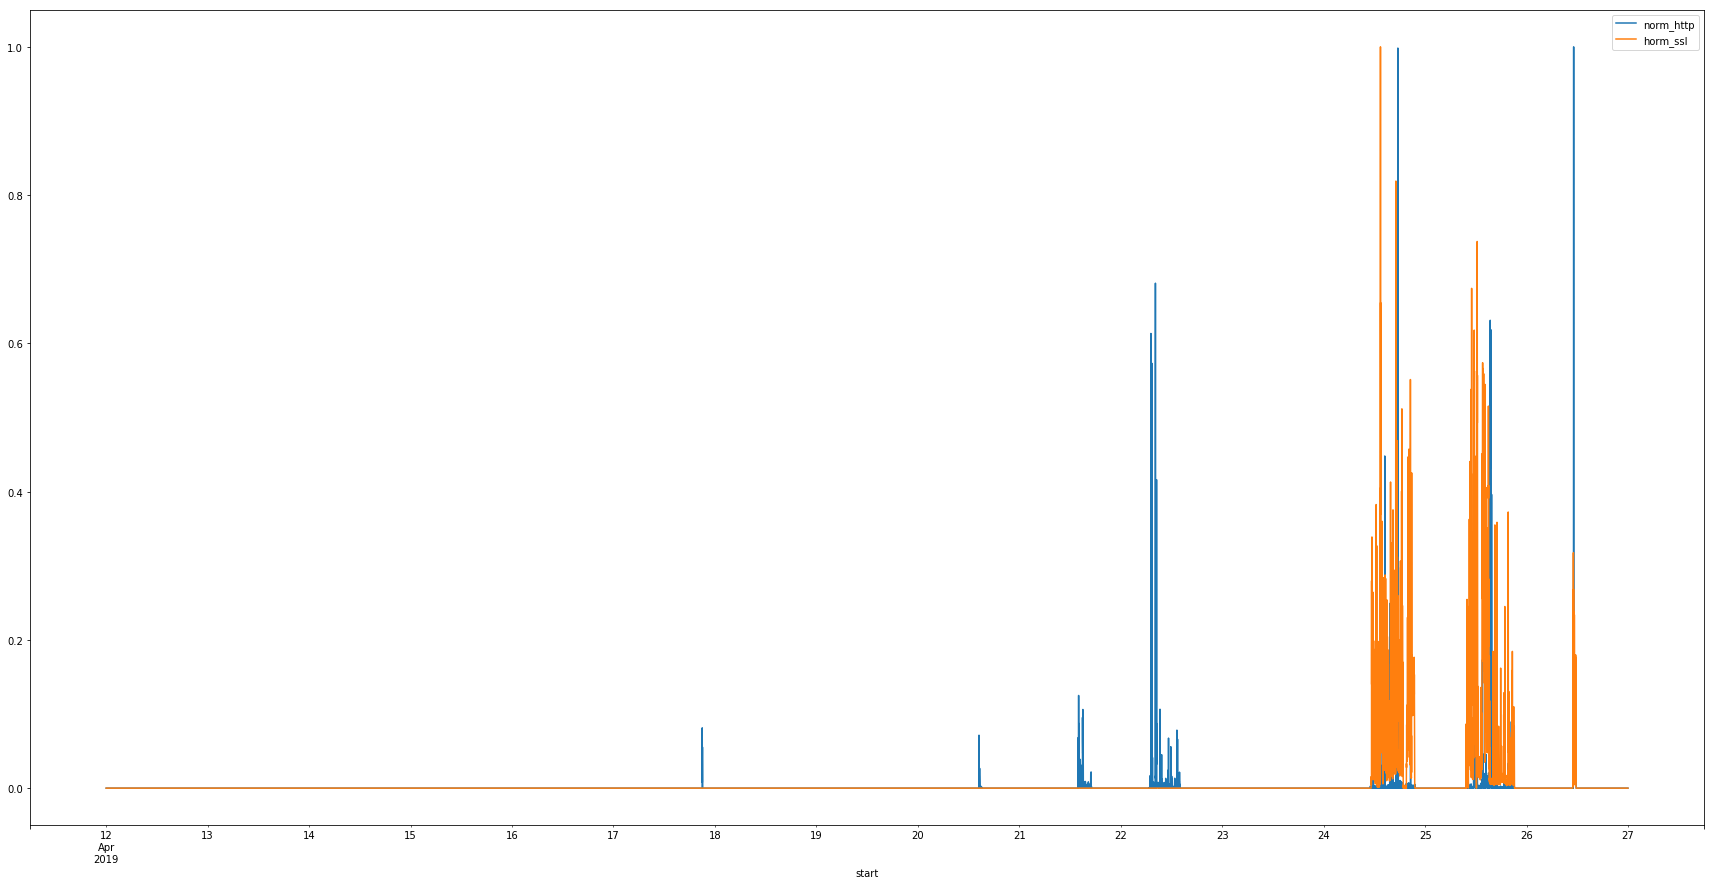

In [96]:
network_norm = data.filter(['norm_http','horm_ssl']).join(snapshots)
network_norm.plot.line(y=['norm_http','horm_ssl'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_norm_plot.png')

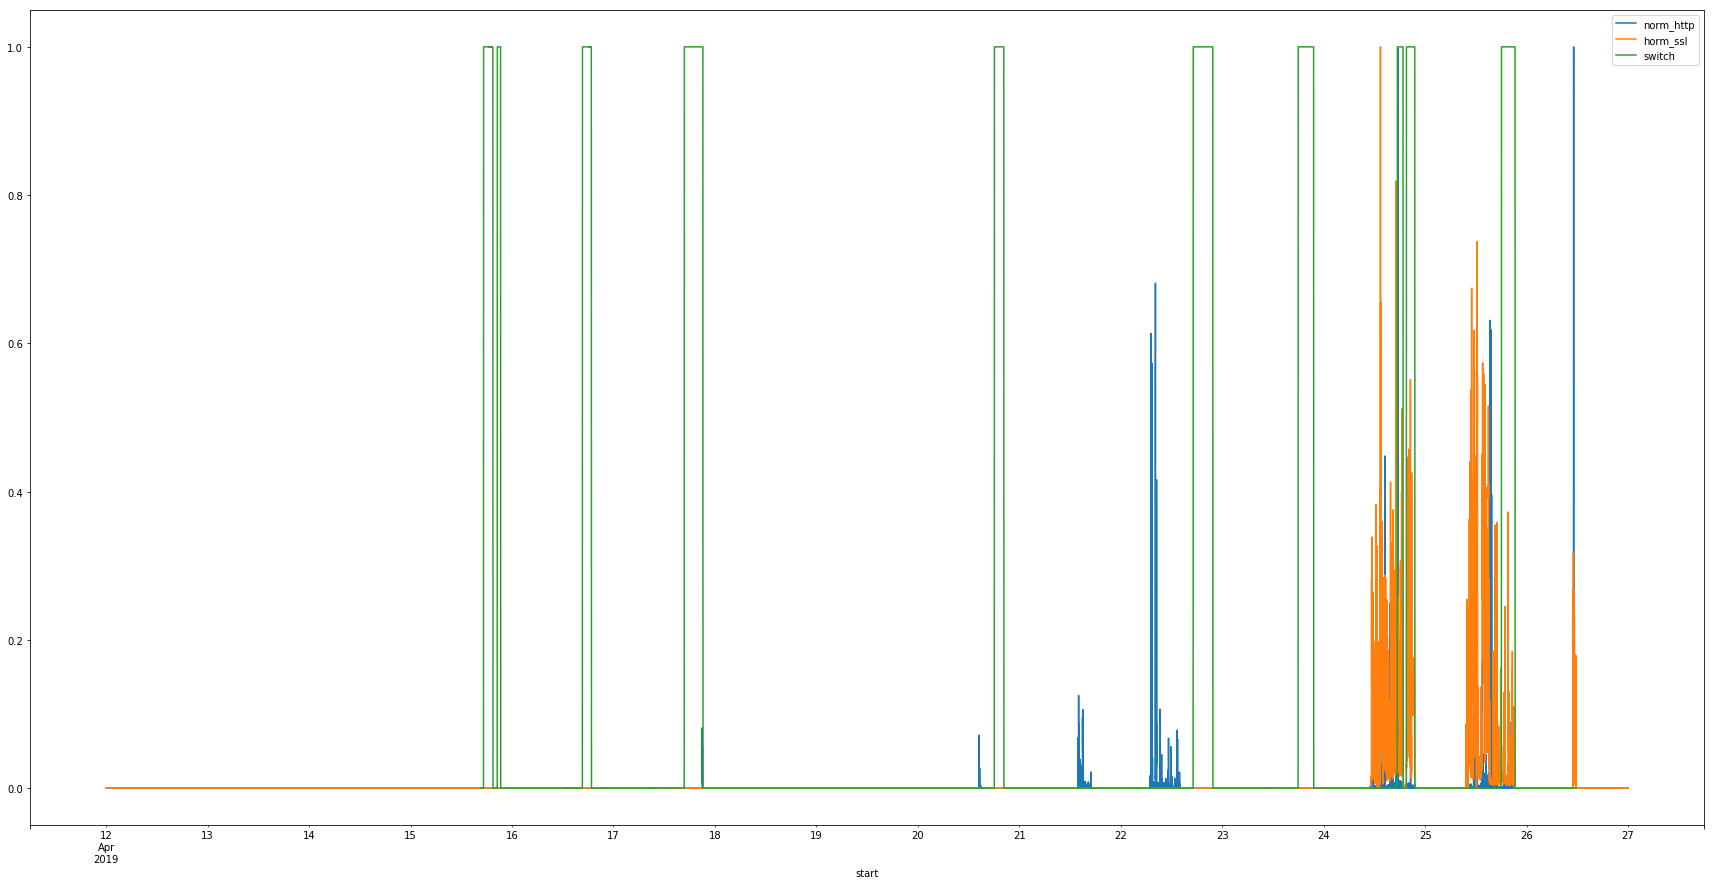

In [97]:
network_switch_norm = data.filter(['norm_http','horm_ssl','switch']).join(snapshots)
network_switch_norm.plot.line(y=['norm_http','horm_ssl','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/network_switch_norm_plot.png')

In [98]:
all_data = data.filter(['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch']).join(snapshots)
all_data.plot.line(y=['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/all_data_plot.png')

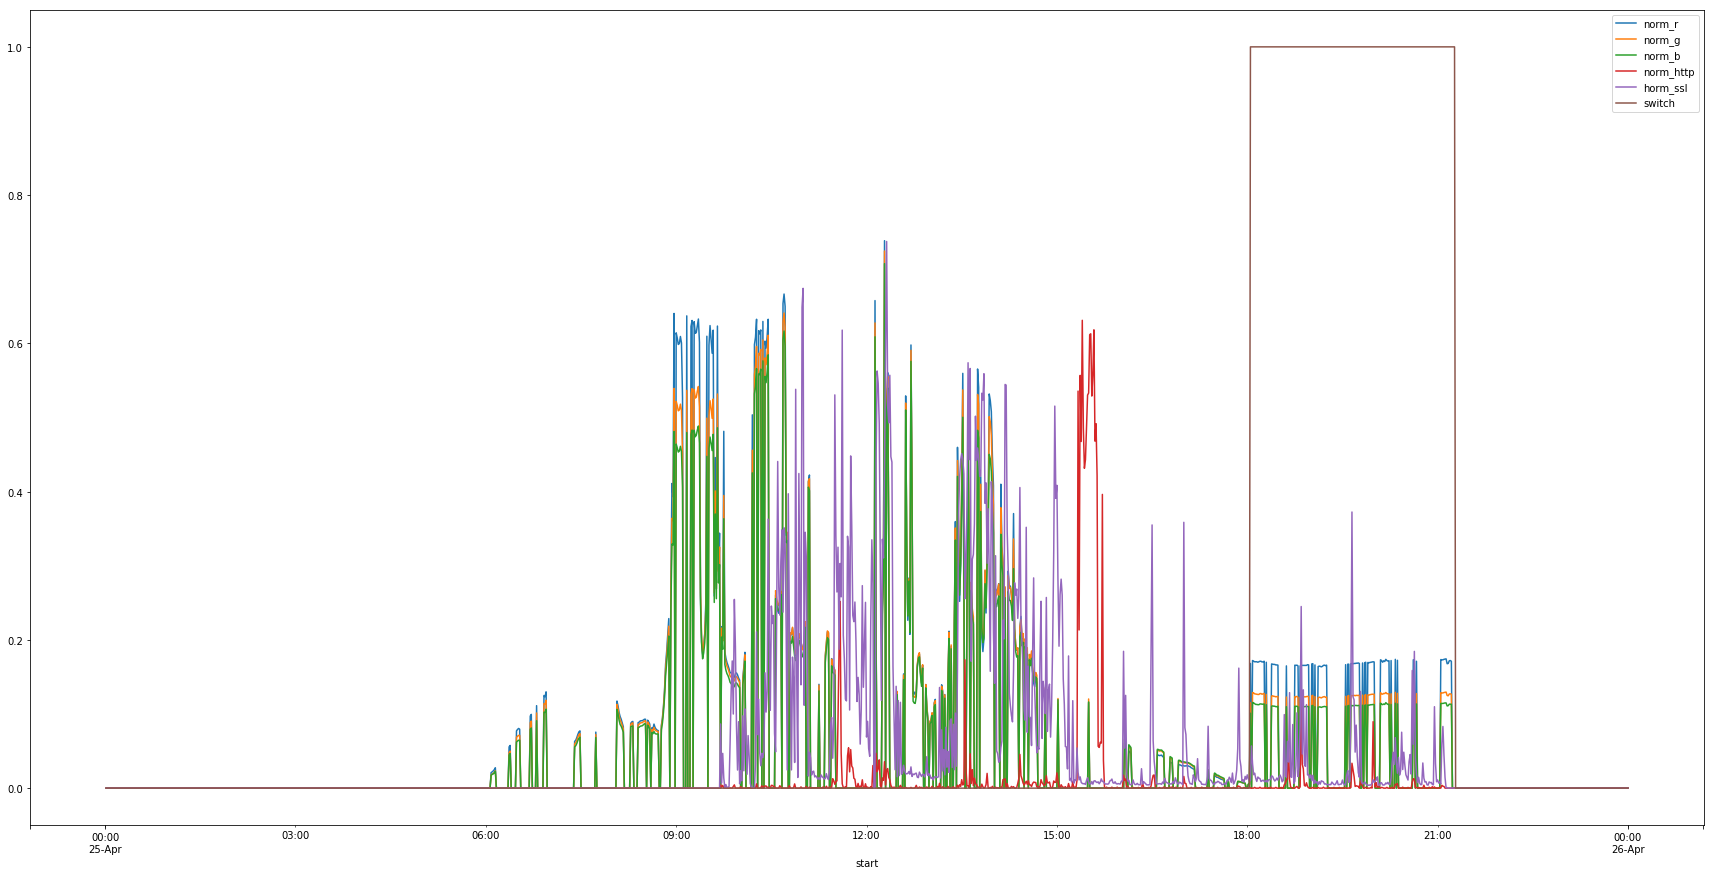

In [99]:
all_data = data.filter(['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch']).join(snapshots)
mask = (all_data['start'] > '2019-04-25 00:00:00') & (all_data['start'] <= '2019-04-26 00:00:00')
all_data.loc[mask].plot.line(y=['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/apr25_26_all_data_plot.png')

In [100]:
all_data = data.filter(['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch']).join(snapshots)
mask = (all_data['start'] > '2019-04-25 15:30:00') & (all_data['start'] <= '2019-04-25 22:00:00')
all_data.loc[mask].plot.line(y=['norm_r','norm_g','norm_b','norm_http','horm_ssl','switch'],x='start',figsize=(30, 15)).get_figure().savefig('./img/apr25_26_1530_2200_all_data_plot.png')